# Scientific Model Comparison

**Thesis: Lap Time Prediction with Physics-Based Features**

This notebook performs a systematic comparison of three model architectures:
1. **Linear Regression** (Ridge regularized) - Baseline
2. **XGBoost** - Gradient Boosting Ensemble
3. **Deep MLP** - Neural Network with 4 hidden layers

All models use the physics-based features (Fuel Load, Tire Degradation, Track Evolution).

---

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Project imports
from src.data_loader import load_laps_for_seasons, clean_laps, enable_cache
from src.features import build_feature_table
from src.models import make_comparison_models, set_global_seed
from src.evaluation import (
    time_based_split,
    compare_models,
    create_comparison_table,
)

# Settings
RANDOM_STATE = 42
TEST_SEASON = 2023
REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(exist_ok=True)

set_global_seed(RANDOM_STATE)
print("Imports successful!")

Imports successful!


---
## 1. Data Loading & Preparation

In [2]:
# Enable cache and load data
enable_cache()

# Load seasons 2022-2023
print("Loading lap data for seasons 2022-2023...")
raw_laps = load_laps_for_seasons([2022, 2023])
print(f"Raw laps loaded: {len(raw_laps):,}")

Loading lap data for seasons 2022-2023...


Race sessions:   0%|          | 0/44 [00:00<?, ?it/s]core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data 

Raw laps loaded: 47,999


In [3]:
# Clean laps
clean_df = clean_laps(raw_laps, exclude_lap1=False, verbose=True)


Lap Cleaning Statistics
Initial laps:  47,999
  - No LapTime: 966 removed
  - IsAccurate=False: 6,111 removed
  - Deleted: 619 removed
Final laps:    40,303 (7,696 removed, 84.0% retained)



In [4]:
# Build feature table with physics features
feature_df, numeric_cols, categorical_cols = build_feature_table(
    clean_df, include_physics=True, verbose=True
)

print(f"\nFeature columns:")
print(f"  Numeric ({len(numeric_cols)}): {numeric_cols}")
print(f"  Categorical ({len(categorical_cols)}): {categorical_cols}")


PHYSICS-BASED FEATURE ENGINEERING

Fuel consumption rates applied for 24 circuits:
  - Sakhir: 2.0 kg/lap
  - Jeddah: 2.1 kg/lap
  - Melbourne: 1.85 kg/lap
  - Imola: 1.85 kg/lap
  - Miami: 1.85 kg/lap
  ... and 19 more circuits

Tire degradation model applied:
  - HARD: 17,199 laps (base grip: 0.94, deg rate: 0.018/lap)
  - MEDIUM: 14,771 laps (base grip: 0.97, deg rate: 0.025/lap)
  - SOFT: 6,085 laps (base grip: 1.0, deg rate: 0.035/lap)
  - INTERMEDIATE: 1,641 laps (base grip: 0.92, deg rate: 0.02/lap)
  - None: 324 laps (base grip: 0.97, deg rate: 0.025/lap)

Track evolution features added:
  - SessionProgress: LapNumber / TotalLaps (0.0 to 1.0)
  - TrackEvolution: log-scaled track rubber-in effect
  - Weather features: None available in data


FEATURE MATRIX SUMMARY
Total samples: 40,303

Numeric features (13):
  - LapNumber: 40,303 non-null values
  - Stint: 40,303 non-null values
  - TyreLife: 39,876 non-null values
  - LapTimeLag1: 39,451 non-null values
  - LapTimeLag2: 38,6

In [5]:
# Time-based split: Train on 2022, Test on 2023
train_df, test_df = time_based_split(feature_df, test_season=TEST_SEASON)

print(f"\nData Split:")
print(f"  Training: {len(train_df):,} samples (Season < {TEST_SEASON})")
print(f"  Test:     {len(test_df):,} samples (Season = {TEST_SEASON})")


Data Split:
  Training: 19,395 samples (Season < 2023)
  Test:     20,908 samples (Season = 2023)


---
## 2. Model Training & Comparison

In [6]:
# Create models for comparison
feature_cols = numeric_cols + categorical_cols

models = make_comparison_models(
    numeric_features=numeric_cols,
    categorical_features=categorical_cols,
    random_state=RANDOM_STATE,
)

print("Models to compare:")
for name in models.keys():
    print(f"  - {name}")

Models to compare:
  - Linear Regression
  - XGBoost
  - Deep MLP


In [7]:
# Run comparison
metrics_df, predictions, table_str = compare_models(
    models=models,
    train_df=train_df,
    test_df=test_df,
    feature_cols=feature_cols,
    target_col="LapTimeSeconds",
    baseline_model="Linear Regression",
    save_path=REPORTS_DIR / "model_comparison_results.csv",
    verbose=True,
)


SCIENTIFIC MODEL COMPARISON
Training samples: 19,395
Test samples:     20,908
Features:         19

Training Linear Regression... MAE: 2.4225, R²: 0.8584
Training XGBoost... MAE: 0.9176, R²: 0.9276
Training Deep MLP... MAE: 2.0088, R²: 0.8550

MODEL COMPARISON - Lap Time Prediction

Model                   MAE (s)   RMSE (s)       R²   MAPE (%)  vs Baseline
------------------------------------------------------------------------------------------
XGBoost                  0.9176     2.9221   0.9276       1.00       +62.1% *
Deep MLP                 2.0088     4.1352   0.8550       2.20       +17.1%
Linear Regression        2.4225     4.0856   0.8584       2.66     baseline
------------------------------------------------------------------------------------------
* Best performing model: XGBoost

DETAILED RESIDUAL ANALYSIS
--------------------------------------------------
Linear Regression: 22.1% within 0.5s, 41.6% within 1.0s
XGBoost: 62.1% within 0.5s, 80.2% within 1.0s
Deep MLP: 30.

In [8]:
# Display metrics table
print("\nMetrics DataFrame:")
metrics_df


Metrics DataFrame:


,model,mae,rmse,r2,mape,std_residuals,max_error
0,XGBoost,0.917568,2.922068,0.927578,1.002843,2.912812,65.160761
1,Deep MLP,2.008833,4.135172,0.854964,2.199008,4.134356,65.079417
2,Linear Regression,2.422495,4.085616,0.858420,2.664124,3.844352,64.903944


---
## 3. Visualization: Model Comparison

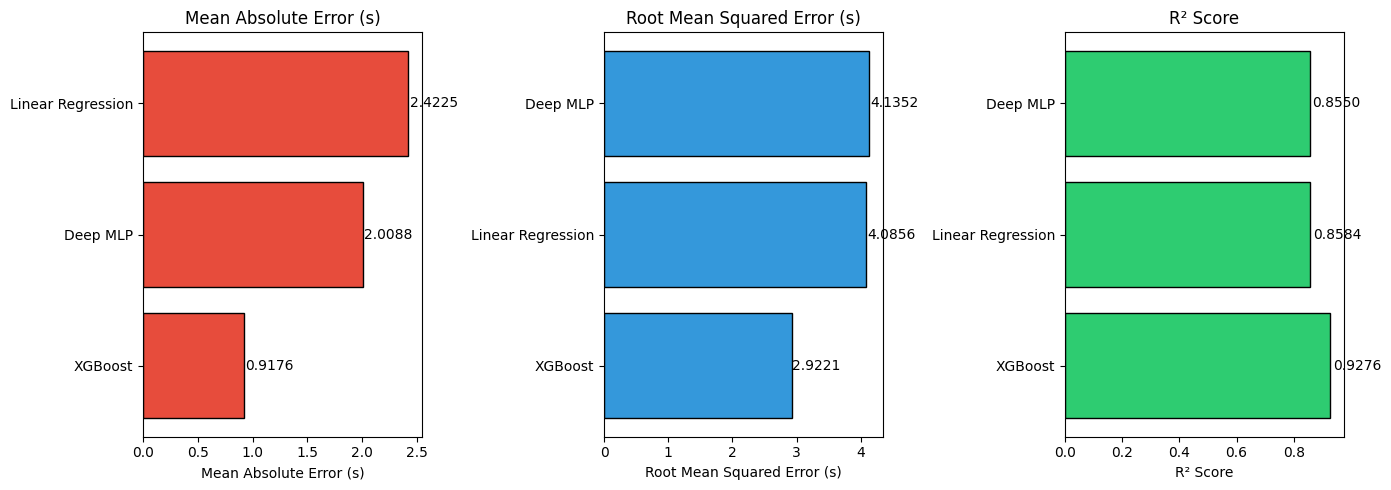

Saved: reports\model_comparison_metrics.png


In [9]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

metrics_to_plot = ['mae', 'rmse', 'r2']
titles = ['Mean Absolute Error (s)', 'Root Mean Squared Error (s)', 'R² Score']
colors = ['#E74C3C', '#3498DB', '#2ECC71']

for ax, metric, title, color in zip(axes, metrics_to_plot, titles, colors):
    data = metrics_df.sort_values(metric, ascending=(metric != 'r2'))
    bars = ax.barh(data['model'], data[metric], color=color, edgecolor='black')
    ax.set_xlabel(title)
    ax.set_title(title)
    
    # Add value labels
    for bar, val in zip(bars, data[metric]):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'model_comparison_metrics.png'}")

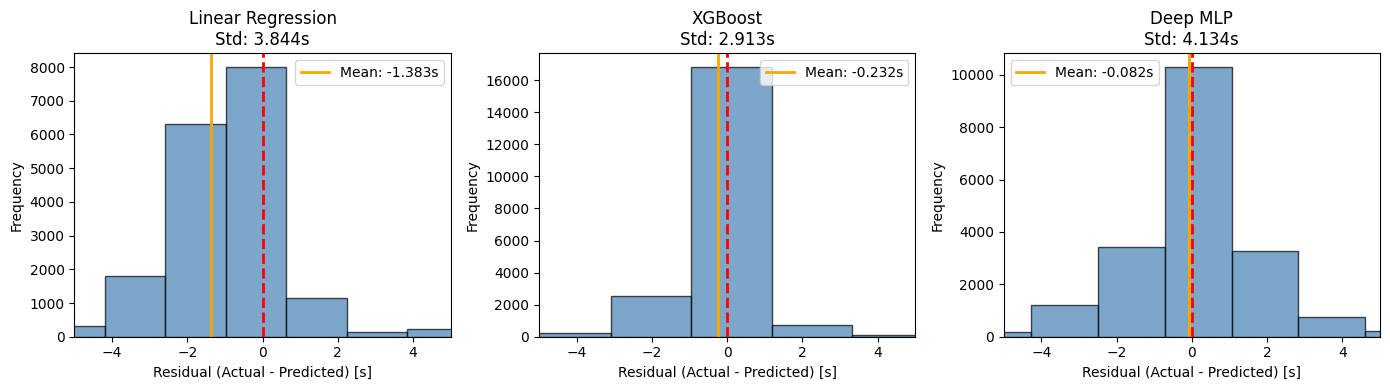

Saved: reports\model_residual_distributions.png


In [10]:
# Residual distribution comparison
y_test = test_df['LapTimeSeconds'].values

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (model_name, preds) in zip(axes, predictions.items()):
    residuals = y_test - preds
    
    ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=np.mean(residuals), color='orange', linestyle='-', linewidth=2, label=f'Mean: {np.mean(residuals):.3f}s')
    ax.set_xlabel('Residual (Actual - Predicted) [s]')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{model_name}\nStd: {np.std(residuals):.3f}s')
    ax.legend()
    ax.set_xlim(-5, 5)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'model_residual_distributions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'model_residual_distributions.png'}")

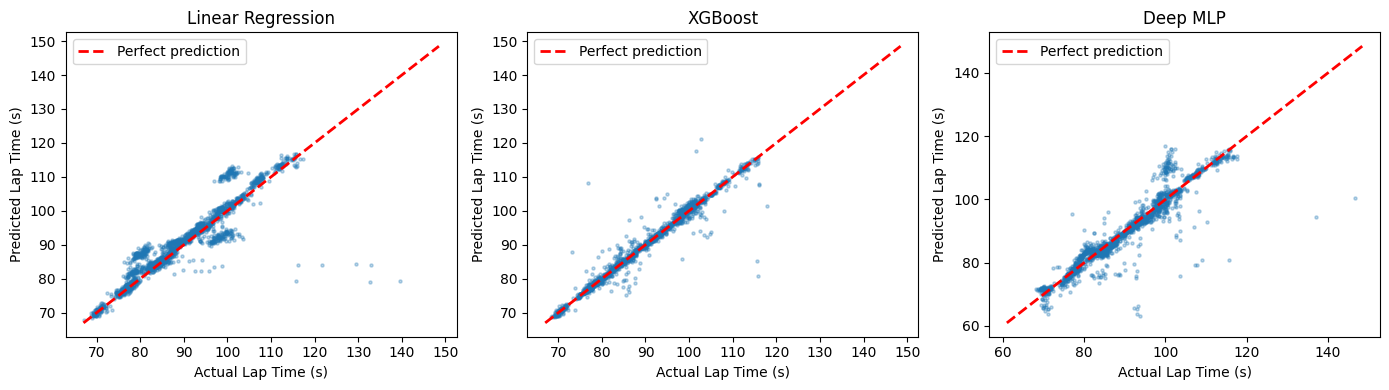

Saved: reports\model_predicted_vs_actual.png


In [11]:
# Predicted vs Actual scatter plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (model_name, preds) in zip(axes, predictions.items()):
    # Sample for visibility
    sample_idx = np.random.choice(len(y_test), size=min(2000, len(y_test)), replace=False)
    
    ax.scatter(y_test[sample_idx], preds[sample_idx], alpha=0.3, s=5)
    
    # Perfect prediction line
    lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Lap Time (s)')
    ax.set_ylabel('Predicted Lap Time (s)')
    ax.set_title(f'{model_name}')
    ax.legend()

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'model_predicted_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'model_predicted_vs_actual.png'}")

---
## 4. Error Analysis by Category

In [12]:
# Error by tire compound
best_model = metrics_df.iloc[0]['model']
best_preds = predictions[best_model]

analysis_df = test_df.copy()
analysis_df['prediction'] = best_preds
analysis_df['abs_error'] = np.abs(analysis_df['LapTimeSeconds'] - analysis_df['prediction'])

# MAE by compound
compound_errors = analysis_df.groupby('Compound')['abs_error'].agg(['mean', 'std', 'count'])
compound_errors.columns = ['MAE', 'Std', 'Count']
compound_errors = compound_errors.sort_values('MAE')

print(f"\nError Analysis by Compound ({best_model}):")
print(compound_errors.round(4))


Error Analysis by Compound (XGBoost):
                 MAE     Std  Count
Compound                           
None          0.4497  0.2997     35
HARD          0.6980  1.9705  10480
MEDIUM        0.9197  3.0562   6987
SOFT          1.1214  3.6297   2792
WET           3.4609  7.5514     39
INTERMEDIATE  3.7606  4.2788    575


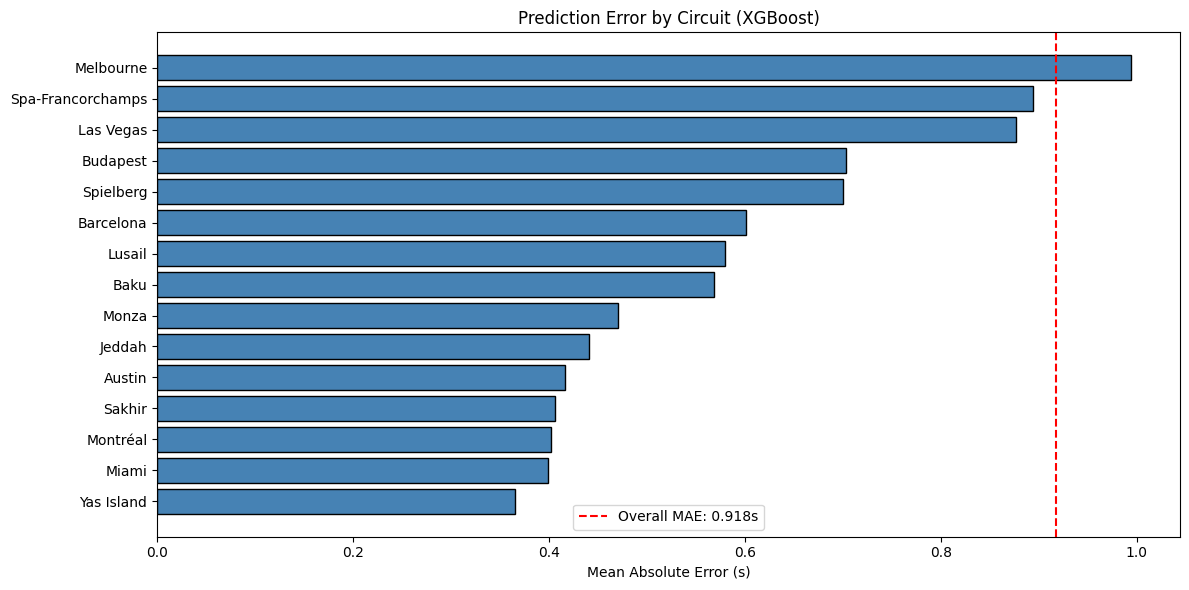

In [13]:
# Error by Circuit
circuit_errors = analysis_df.groupby('Circuit')['abs_error'].agg(['mean', 'std', 'count'])
circuit_errors.columns = ['MAE', 'Std', 'Count']
circuit_errors = circuit_errors.sort_values('MAE')

fig, ax = plt.subplots(figsize=(12, 6))
circuits = circuit_errors.head(15).index.tolist()
maes = circuit_errors.head(15)['MAE'].values

bars = ax.barh(circuits, maes, color='steelblue', edgecolor='black')
ax.set_xlabel('Mean Absolute Error (s)')
ax.set_title(f'Prediction Error by Circuit ({best_model})')
ax.axvline(x=analysis_df['abs_error'].mean(), color='red', linestyle='--', label=f'Overall MAE: {analysis_df["abs_error"].mean():.3f}s')
ax.legend()

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'error_by_circuit.png', dpi=150, bbox_inches='tight')
plt.show()

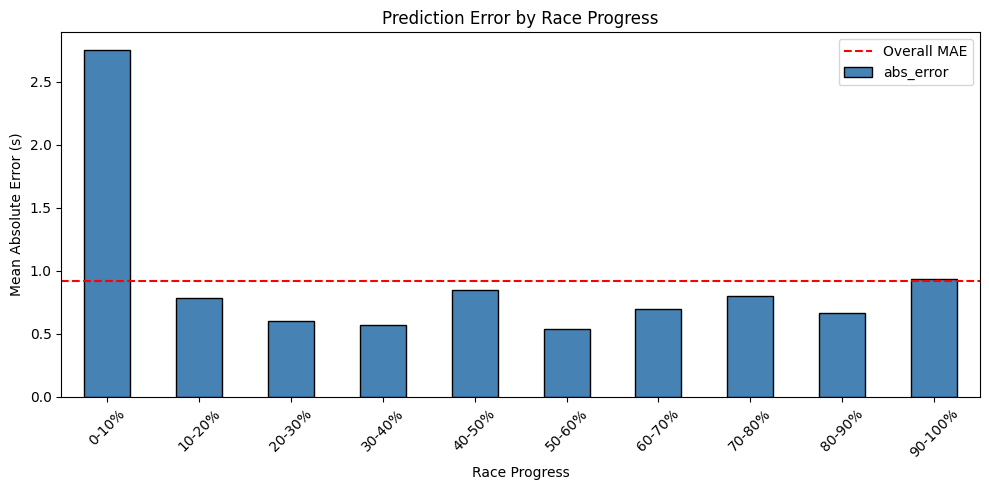

In [14]:
# Error by Session Progress (track evolution effect)
if 'SessionProgress' in analysis_df.columns:
    analysis_df['ProgressBin'] = pd.cut(analysis_df['SessionProgress'], bins=10, labels=[f'{i*10}-{(i+1)*10}%' for i in range(10)])
    
    progress_errors = analysis_df.groupby('ProgressBin')['abs_error'].mean()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    progress_errors.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Race Progress')
    ax.set_ylabel('Mean Absolute Error (s)')
    ax.set_title('Prediction Error by Race Progress')
    ax.axhline(y=analysis_df['abs_error'].mean(), color='red', linestyle='--', label='Overall MAE')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'error_by_race_progress.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## 5. Physics Features Impact Analysis

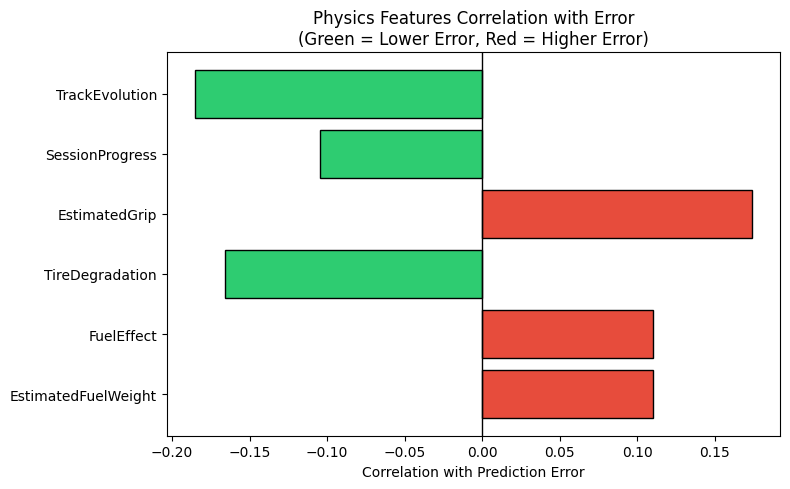


Physics Feature Correlation with Prediction Error:
  EstimatedFuelWeight: +0.1103
  FuelEffect: +0.1103
  TireDegradation: -0.1657
  EstimatedGrip: +0.1740
  SessionProgress: -0.1046
  TrackEvolution: -0.1854


In [15]:
# Correlation of physics features with prediction error
physics_features = ['EstimatedFuelWeight', 'FuelEffect', 'TireDegradation', 
                    'EstimatedGrip', 'SessionProgress', 'TrackEvolution']

available_physics = [f for f in physics_features if f in analysis_df.columns]

if available_physics:
    corr_with_error = analysis_df[available_physics + ['abs_error']].corr()['abs_error'].drop('abs_error')
    
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = ['#2ECC71' if c < 0 else '#E74C3C' for c in corr_with_error.values]
    bars = ax.barh(corr_with_error.index, corr_with_error.values, color=colors, edgecolor='black')
    ax.axvline(x=0, color='black', linewidth=1)
    ax.set_xlabel('Correlation with Prediction Error')
    ax.set_title('Physics Features Correlation with Error\n(Green = Lower Error, Red = Higher Error)')
    
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'physics_features_error_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nPhysics Feature Correlation with Prediction Error:")
    for feat, corr in corr_with_error.items():
        print(f"  {feat}: {corr:+.4f}")

---
## 6. LaTeX Table for Thesis

In [16]:
# Generate LaTeX table
latex_table = create_comparison_table(metrics_df, baseline_model="Linear Regression", latex=True)
print("LaTeX Table for Thesis:")
print("=" * 60)
print(latex_table)
print("=" * 60)

# Save to file
with open(REPORTS_DIR / 'model_comparison_table.tex', 'w') as f:
    f.write(latex_table)
print(f"\nSaved: {REPORTS_DIR / 'model_comparison_table.tex'}")

LaTeX Table for Thesis:
\begin{table}[htbp]
\centering
\caption{Model Comparison for Lap Time Prediction}
\label{tab:model_comparison}
\begin{tabular}{lrrrrr}
\toprule
Model & MAE (s) & RMSE (s) & $R^2$ & MAPE (\%) & Improvement \\
\midrule
\textbf{XGBoost} & 0.9176 & 2.9221 & 0.9276 & 1.00 & +62.1\% \\
Deep MLP & 2.0088 & 4.1352 & 0.8550 & 2.20 & +17.1\% \\
Linear Regression & 2.4225 & 4.0856 & 0.8584 & 2.66 & --- \\
\bottomrule
\end{tabular}
\end{table}

Saved: reports\model_comparison_table.tex


---
## 7. Summary & Conclusions

In [17]:
# Final summary
print("\n" + "=" * 70)
print("SCIENTIFIC MODEL COMPARISON - FINAL SUMMARY")
print("=" * 70)

print(f"\nDataset:")
print(f"  - Training: {len(train_df):,} laps (Season 2022)")
print(f"  - Test: {len(test_df):,} laps (Season 2023)")
print(f"  - Features: {len(numeric_cols)} numeric + {len(categorical_cols)} categorical")

print(f"\nPhysics-Based Features Used:")
for feat in ['EstimatedFuelWeight', 'EstimatedGrip', 'SessionProgress', 'TrackEvolution']:
    if feat in numeric_cols:
        print(f"  - {feat}")

print(f"\nModel Performance (sorted by MAE):")
for _, row in metrics_df.iterrows():
    print(f"  {row['model']:<20} MAE: {row['mae']:.4f}s  R²: {row['r2']:.4f}")

best = metrics_df.iloc[0]
baseline = metrics_df[metrics_df['model'] == 'Linear Regression'].iloc[0]
improvement = (baseline['mae'] - best['mae']) / baseline['mae'] * 100

print(f"\nKey Findings:")
print(f"  - Best Model: {best['model']}")
print(f"  - MAE Improvement over Baseline: {improvement:.1f}%")
print(f"  - Best MAE: {best['mae']:.4f} seconds")
print(f"  - Best R²: {best['r2']:.4f}")

print("\n" + "=" * 70)


SCIENTIFIC MODEL COMPARISON - FINAL SUMMARY

Dataset:
  - Training: 19,395 laps (Season 2022)
  - Test: 20,908 laps (Season 2023)
  - Features: 13 numeric + 6 categorical

Physics-Based Features Used:
  - EstimatedFuelWeight
  - EstimatedGrip
  - SessionProgress
  - TrackEvolution

Model Performance (sorted by MAE):
  XGBoost              MAE: 0.9176s  R²: 0.9276
  Deep MLP             MAE: 2.0088s  R²: 0.8550
  Linear Regression    MAE: 2.4225s  R²: 0.8584

Key Findings:
  - Best Model: XGBoost
  - MAE Improvement over Baseline: 62.1%
  - Best MAE: 0.9176 seconds
  - Best R²: 0.9276



In [18]:
# List all saved files
print("\nGenerated Reports:")
for f in sorted(REPORTS_DIR.glob('*')):
    print(f"  - {f.name}")


Generated Reports:
  - compound_distribution.png
  - error_by_circuit.png
  - error_by_race_progress.png
  - feature_importance_xgboost_top10.png
  - fuel_load_demonstration.png
  - laptime_correlation_ranking.png
  - model_comparison_metrics.png
  - model_comparison_results.csv
  - model_comparison_table.tex
  - model_predicted_vs_actual.png
  - model_residual_distributions.png
  - physics_features_correlation_matrix.png
  - physics_features_error_correlation.png
  - spa_2023_pred_vs_actual.png
  - tire_degradation_comparison.png
